In [1]:
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import os, os.path
import keras
import time
import scipy.misc
import scipy.ndimage

from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import CSVLogger

from keras import backend as K
from keras.initializers import RandomUniform, RandomNormal

from PIL import Image

from tqdm import tqdm
from datetime import datetime

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K40m (CNMeM is disabled, cuDNN 5110)


In [2]:
# resolution of images

h = 75
w = 100

In [3]:
#Creates list of positiv files
positiv_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/pos/IMG_*.png')
#Finds the number of positiv files
positiv_len = len(positiv_list)
print("Size of positiv Sample: {}".format(positiv_len))

#Same but for negativ files
negativ_list = glob.glob('/fhgfs/groups/e5/lhcb/detector/scifi/windingcontrol/Images_Sep17/neg/IMG_*.png')
negativ_len = len(negativ_list)
print("Size of negativ Sample: {}".format(negativ_len))

Size of positiv Sample: 8590
Size of negativ Sample: 13846


In [4]:
X_posind = []
X_negind = []
X_posinu = []
X_neginu = []
X_posinl = []
X_neginl = []
X_posinr = []
X_neginr = []

X_pos = []
X_neg = []

for fname in tqdm(positiv_list):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_posind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_posinu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_posinr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_posinl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_pos.append(img) 
    
# Random picking of neg images with the given ratio to the pos images
ratio_pos_neg = 1

for fname in tqdm(negativ_list):
#for fname in tqdm(np.random.choice(negativ_list, replace=False, size=int(len(X_pos) / ratio_pos_neg))):
    img = scipy.misc.imresize(np.array(Image.open(fname)),(h,w))
    
    #X_negind.append(scipy.ndimage.interpolation.shift(img, (20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    #X_neginu.append(scipy.ndimage.interpolation.shift(img, (-20,0), output=None, order=1, mode='nearest', cval=0.0, prefilter=True))
    
    #X_neginr.append(scipy.ndimage.interpolation.shift(img, (0,50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    #X_neginl.append(scipy.ndimage.interpolation.shift(img, (0,-50), output=None, order=1, mode='reflect', cval=0.0, prefilter=True))
    
    X_neg.append(img)

100%|██████████| 13846/13846 [00:27<00:00, 495.01it/s]


In [5]:
X_posind = np.array(X_posind)
X_negind = np.array(X_negind)
X_posinu = np.array(X_posinu)
X_neginu = np.array(X_neginu)
X_posinl = np.array(X_posinl)
X_neginl = np.array(X_neginl)
X_posinr = np.array(X_posinr)
X_neginr = np.array(X_neginr)
X_pos = np.array(X_pos)
X_neg = np.array(X_neg)

In [6]:
X_all = np.concatenate((X_pos, X_neg), axis=0)
Y_all = np.concatenate( ( np.ones(len(X_pos)), np.zeros(len(X_neg)) ) , axis=0)
#X_all_trans = np.concatenate((X_pos, X_posind, X_posinu, X_posinl, X_posinr, X_neg, X_negind, X_neginu, X_neginl, X_neginr), axis=0)
#Y_all_trans = np_utils.to_categorical(np.concatenate((np.ones((5*positiv_len, 1)), np.zeros((5*negativ_len,1))), axis=0), 2)

In [7]:
X_all.shape

(22436, 75, 100)

In [8]:
Y_all.shape

(22436,)

In [9]:
#Shuffling the order of the input - required to avoid batches selecting only positive/negative images
randomize = np.arange(len(X_all))
np.random.shuffle(randomize)
X_all = X_all[randomize]
Y_all = Y_all[randomize]

In [10]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_all[:200]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_all[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [11]:
# Hold 5% back as training data
train_split = int(0.05 * len(X_all))

# Separate in Training and Testing Sample
X_train = X_all[train_split:]
Y_train = Y_all[train_split:]

X_test = X_all[:train_split]
Y_test = Y_all[:train_split]

In [12]:
# Check labeling of Data
if False:
    for i, img in enumerate(X_test[:100]):
        plt.imshow(np.squeeze(img), cmap='gray')

        name = "Good img" if Y_test[i] == 1 else "Bad img"
        plt.title('{}.'.format(name))
        plt.savefig('../Plots/TestImg/{}.png'.format(i))
        if i%10 == 0:
            print("10 written")
        i+=1

In [13]:
X_train = X_train.reshape(X_train.shape[0], h, w, 1)
X_test = X_test.reshape(X_test.shape[0], h, w, 1)

#Shape check (NumberofImages, Height, Width, Depth)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(21315, 75, 100, 1)
(21315,)
(1121, 75, 100, 1)
(1121,)


# Data need to be normalised
* Mean and StdDev for each pixel over whole data set

In [14]:
X_train.shape

(21315, 75, 100, 1)

In [15]:
means = np.mean(X_train, axis=0)
stds = np.std(X_train, axis=0)

#means_30_40 = np.mean(X_train_30_40, axis=0)
#stds_30_40 = np.std(X_train_30_40, axis=0)

In [16]:
print(means.shape)
print(stds.shape)
#print(means_30_40.shape)
#print(stds_30_40.shape)

(75, 100, 1)
(75, 100, 1)


In [17]:
path_meanstd = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/MeansStdDev/'

if not os.path.exists(path_meanstd):
    os.makedirs(path_meanstd)
    print('Created path: {}'.format(path_meanstd))
                                            
#np.savetxt('../Data/Means_30_40.txt', means_30_40)
#np.savetxt('../Data/StdDev_30_40.txt', stds_30_40)
np.savetxt(path_meanstd +'Means_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', means)
np.savetxt(path_meanstd +'StdDev_' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) +  '.txt', stds)

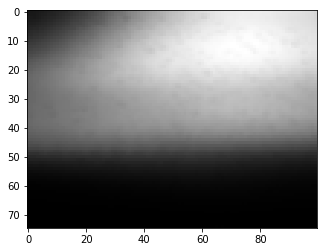

In [18]:
plt.imshow(np.squeeze(means), cmap='gray')
plt.savefig(path_meanstd + 'MeanImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

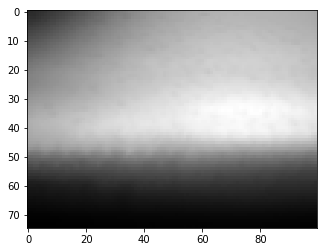

In [19]:
plt.imshow(np.squeeze(stds), cmap='gray')
plt.savefig(path_meanstd + 'StdImg' +  str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.png')

In [20]:
X_train_norm = np.array([(img-means)/stds for img in X_train])
X_test_norm = np.array([(img-means)/stds for img in X_test])

# Let the training begin...

In [21]:
## Class to get loss and accuracy during training of NN

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('acc'))

In [22]:
input_shape= (h,w,1)
#input_shape_30_40= (x_new,y_new,1)

* initializer need to have mean = 0 and std 1/input_shape
* for successive layers output shape of previous layer will declare this

### Models with 3 Conv Layer and 2 Fully Connected

In [23]:
names_3Conv_2Fully = ['167_165_163_200_200', '165_165_163_200_200', '165_163_163_200_200']

In [24]:
kernel_sizes_3Conv_2Fully = [(7,5,3), (5,5,3), (5,3,3)]

In [25]:
for name, k_size in zip(names_3Conv_2Fully, kernel_sizes_3Conv_2Fully):    
    print('Name: {}\tKernelsize: {}'.format(name, k_size))
    #print('k_sizes: {},{},{}'.format(k_size[0], k_size[1], k_size[2]))
    
    ## Path for Model saving!
    path_model = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/'

    if not os.path.exists(path_model):
        os.makedirs(path_model)
        print('Created path: {}'.format(path_model))
        
    ##### MODEL #####
    model = Sequential()

    # First Convolutional layer initialised with random input weights
    model.add(Conv2D(16, (k_size[0], k_size[0]), kernel_initializer=RandomNormal(mean=0, stddev=1/(h*w)), padding='valid', input_shape=input_shape, activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))
    mult_shape1 = np.prod(model.layers[1].output_shape[1:])

    # Second Convolutional layer
    model.add(Conv2D(16, (k_size[1], k_size[1]), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))
    mult_shape2 = np.prod(model.layers[3].output_shape[1:])

    # Third Convolutional layer
    model.add(Conv2D(16, (k_size[2], k_size[2]), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2), padding='valid', activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))

    #Converting the 2D images to 1D vectors
    model.add(Flatten())  
    mult_shape3 = np.prod(model.layers[6].output_shape[1:])

    # First Fully connected layer
    model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape3)))
    model.add(Dropout(0.2))
    mult_shape4 = np.prod(model.layers[8].output_shape[1:])

    # Second Fully connected layer
    model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))
    model.add(Dropout(0.2))
    mult_shape5 = np.prod(model.layers[10].output_shape[1:])

    #Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape5)))
    
    #### END OF MODEL ####
    
    model.summary()
    
    ## Save the Model and create Data path!
    path_data = '../Data/{}/{}/'.format(str(datetime.now().strftime('%Y-%m-%d')), name )

    if not os.path.exists(path_data):
        os.makedirs(path_data)
        print('Created path: {}'.format(path_data))

    # Open the file
    with open(path_data + 'ModelSummary.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        model.summary(print_fn=lambda x: fh.write(x + '\n'))
        
    
    #Defining optimiser and compiling the model
    model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])

    history = LossHistory()
    
    ## Start the training!
    model.fit(X_train_norm, Y_train,  batch_size=76, epochs=100, verbose=1, validation_split = 0.05, callbacks=[history])

    #Evaluating trained model on test images
    score = model.evaluate(X_test_norm, Y_test, verbose=0)
    print('Model has accuracy:', score[1]*100,'%')
    
    # Save trained NN
    model.save(path_model + name + '.h5')
    np.savetxt(path_model + name + '_TrainingData.txt', np.transpose([history.accuracy, history.losses]))
    
    ### Performance on Testdata! ###
    # Get probs per image
    probs = []

    i=0 
    for img in X_test_norm:
        #plt.imshow(np.squeeze(img), cmap='gray')

        img = np.reshape(img, [1,h,w,1])
        p = model.predict_proba(img, verbose=0)
        probs.append(np.squeeze(p))

        #name = "Good img" if Y_test[i, 1] == 1 else "Bad img"
        #plt.title('{}. Score: [{:.4f}, {:.4f}]'.format(name, p[0,0], p[0,1]))
        #plt.savefig('../Plots/TestImg/{}.png'.format(i))
        i+=1

    probs = np.array(probs)
    
    np.savetxt(path_data + 'ScoresOnTestData.txt', np.transpose([Y_test, probs]))
    
    

Name: 167_165_163_200_200	Kernelsize: (7, 5, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 69, 94, 16)        800       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 43, 16)        6416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 21, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 19, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 9, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)         

20249/20249 [==============================] - 66s - loss: 0.0122 - acc: 0.9964 - val_loss: 0.0171 - val_acc: 0.9981
Epoch 49/100
20249/20249 [==============================] - 66s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0460 - val_acc: 0.9916
Epoch 50/100
20249/20249 [==============================] - 66s - loss: 0.0063 - acc: 0.9980 - val_loss: 0.0165 - val_acc: 0.9972
Epoch 51/100
20249/20249 [==============================] - 66s - loss: 0.0038 - acc: 0.9989 - val_loss: 0.0172 - val_acc: 0.9981
Epoch 52/100
20249/20249 [==============================] - 67s - loss: 0.0051 - acc: 0.9989 - val_loss: 0.0642 - val_acc: 0.9897
Epoch 53/100
20249/20249 [==============================] - 66s - loss: 0.0105 - acc: 0.9969 - val_loss: 0.0373 - val_acc: 0.9944
Epoch 54/100
20249/20249 [==============================] - 66s - loss: 0.0048 - acc: 0.9985 - val_loss: 0.0135 - val_acc: 0.9981
Epoch 55/100
20249/20249 [==============================] - 66s - loss: 0.0017 - acc: 0.9994 - val_loss

Total params: 241,753
Trainable params: 241,753
Non-trainable params: 0
_________________________________________________________________
Created path: ../Data/2017-09-16/165_165_163_200_200/
Train on 20249 samples, validate on 1066 samples
Epoch 1/100
20249/20249 [==============================] - 69s - loss: 0.5622 - acc: 0.7191 - val_loss: 0.4556 - val_acc: 0.7974
Epoch 2/100
20249/20249 [==============================] - 69s - loss: 0.4440 - acc: 0.7867 - val_loss: 0.3398 - val_acc: 0.8265
Epoch 3/100
20249/20249 [==============================] - 69s - loss: 0.3310 - acc: 0.8456 - val_loss: 0.2195 - val_acc: 0.9118
Epoch 4/100
20249/20249 [==============================] - 69s - loss: 0.2512 - acc: 0.8881 - val_loss: 0.2405 - val_acc: 0.9081
Epoch 5/100
20249/20249 [==============================] - 68s - loss: 0.1740 - acc: 0.9301 - val_loss: 0.1048 - val_acc: 0.9587
Epoch 6/100
20249/20249 [==============================] - 69s - loss: 0.1139 - acc: 0.9544 - val_loss: 0.0702 - v

20249/20249 [==============================] - 69s - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0110 - val_acc: 0.9981
Epoch 63/100
20249/20249 [==============================] - 69s - loss: 5.4929e-04 - acc: 0.9998 - val_loss: 0.0144 - val_acc: 0.9962
Epoch 64/100
20249/20249 [==============================] - 69s - loss: 1.8163e-04 - acc: 0.9999 - val_loss: 0.0110 - val_acc: 0.9981
Epoch 65/100
20249/20249 [==============================] - 69s - loss: 9.4014e-05 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9972
Epoch 66/100
20249/20249 [==============================] - 69s - loss: 0.0072 - acc: 0.9981 - val_loss: 0.0189 - val_acc: 0.9953
Epoch 67/100
20249/20249 [==============================] - 69s - loss: 0.0134 - acc: 0.9965 - val_loss: 0.0045 - val_acc: 0.9972
Epoch 68/100
20249/20249 [==============================] - 69s - loss: 0.0039 - acc: 0.9986 - val_loss: 0.0154 - val_acc: 0.9962
Epoch 69/100
20249/20249 [==============================] - 69s - loss: 0.0026 - acc: 0.999

20249/20249 [==============================] - 69s - loss: 0.0250 - acc: 0.9915 - val_loss: 0.0276 - val_acc: 0.9925
Epoch 9/100
20249/20249 [==============================] - 69s - loss: 0.0228 - acc: 0.9915 - val_loss: 0.0355 - val_acc: 0.9916
Epoch 10/100
20249/20249 [==============================] - 69s - loss: 0.0139 - acc: 0.9952 - val_loss: 0.0426 - val_acc: 0.9925
Epoch 11/100
20249/20249 [==============================] - 69s - loss: 0.0210 - acc: 0.9922 - val_loss: 0.0279 - val_acc: 0.9944
Epoch 12/100
20249/20249 [==============================] - 69s - loss: 0.0112 - acc: 0.9963 - val_loss: 0.0315 - val_acc: 0.9962
Epoch 13/100
20249/20249 [==============================] - 69s - loss: 0.0093 - acc: 0.9966 - val_loss: 0.0418 - val_acc: 0.9944
Epoch 14/100
20249/20249 [==============================] - 69s - loss: 0.0146 - acc: 0.9952 - val_loss: 0.0509 - val_acc: 0.9887
Epoch 15/100
20249/20249 [==============================] - 69s - loss: 0.0069 - acc: 0.9979 - val_loss:

20249/20249 [==============================] - 68s - loss: 1.5368e-04 - acc: 1.0000 - val_loss: 0.0291 - val_acc: 0.9962
Epoch 71/100
20249/20249 [==============================] - 68s - loss: 0.0065 - acc: 0.9981 - val_loss: 0.0160 - val_acc: 0.9991
Epoch 72/100
20249/20249 [==============================] - 69s - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0091 - val_acc: 0.9972
Epoch 73/100
20249/20249 [==============================] - 68s - loss: 0.0057 - acc: 0.9988 - val_loss: 0.0097 - val_acc: 0.9981
Epoch 74/100
20249/20249 [==============================] - 68s - loss: 0.0018 - acc: 0.9995 - val_loss: 0.0201 - val_acc: 0.9981
Epoch 75/100
20249/20249 [==============================] - 68s - loss: 9.1820e-04 - acc: 0.9997 - val_loss: 0.0043 - val_acc: 0.9981
Epoch 76/100
20249/20249 [==============================] - 68s - loss: 0.0010 - acc: 0.9998 - val_loss: 0.0065 - val_acc: 0.9981
Epoch 77/100
20249/20249 [==============================] - 69s - loss: 0.0012 - acc: 0.9995 - 

### Models with 3 Conv Layer and 1 Fully Connected

In [26]:
names_3Conv_1Fully = ['167_165_163_200', '165_165_163_200', '165_163_163_200']

In [27]:
kernel_sizes_3Conv_1Fully = [(7,5,3), (5,5,3), (5,3,3)]

In [28]:
for name, k_size in zip(names_3Conv_1Fully, kernel_sizes_3Conv_1Fully):
    print('Name: {}\tKernelsize: {}'.format(name, k_size))
    #print('k_sizes: {},{},{}'.format(k_size[0], k_size[1], k_size[2]))
    
    ## Path for Model saving!
    path_model = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/'

    if not os.path.exists(path_model):
        os.makedirs(path_model)
        print('Created path: {}'.format(path_model))
    
    #### MODEL ####
    model = Sequential()

    # First Convolutional layer initialised with random input weights
    model.add(Conv2D(16, (k_size[0], k_size[0]), kernel_initializer=RandomNormal(mean=0, stddev=1/(h*w)), padding='valid', input_shape=input_shape, activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))
    mult_shape1 = np.prod(model.layers[1].output_shape[1:])

    # Second Convolutional layer
    model.add(Conv2D(16, (k_size[1], k_size[1]), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))
    mult_shape2 = np.prod(model.layers[3].output_shape[1:])

    # Third Convolutional layer
    model.add(Conv2D(16, (k_size[2], k_size[2]), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2), padding='valid', activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))

    #Converting the 2D images to 1D vectors
    model.add(Flatten())  
    mult_shape3 = np.prod(model.layers[6].output_shape[1:])

    # First Fully connected layer
    model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape3)))
    model.add(Dropout(0.2))
    mult_shape4 = np.prod(model.layers[8].output_shape[1:])

    #Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))
    
    #### END OF MODEL ####
    
    model.summary()
    
    ## Save the Model and create Data path!
    path_data = '../Data/{}/{}/'.format(str(datetime.now().strftime('%Y-%m-%d')), name )

    if not os.path.exists(path_data):
        os.makedirs(path_data)
        print('Created path: {}'.format(path_data))

    # Open the file
    with open(path_data + 'ModelSummary.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        model.summary(print_fn=lambda x: fh.write(x + '\n'))
        
    
    #Defining optimiser and compiling the model
    model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])

    history = LossHistory()
    
    ## Start the training!
    model.fit(X_train_norm, Y_train,  batch_size=76, epochs=100, verbose=1, validation_split = 0.05, callbacks=[history])

    #Evaluating trained model on test images
    score = model.evaluate(X_test_norm, Y_test, verbose=0)
    print('Model has accuracy:', score[1]*100,'%')
    
    # Save trained NN
    model.save(path_model + name + '.h5')
    np.savetxt(path_model + name + '_TrainingData.txt', np.transpose([history.accuracy, history.losses]))
    
    ### Performance on Testdata! ###
    # Get probs per image
    probs = []

    i=0 
    for img in X_test_norm:
        #plt.imshow(np.squeeze(img), cmap='gray')

        img = np.reshape(img, [1,h,w,1])
        p = model.predict_proba(img, verbose=0)
        probs.append(np.squeeze(p))

        #name = "Good img" if Y_test[i, 1] == 1 else "Bad img"
        #plt.title('{}. Score: [{:.4f}, {:.4f}]'.format(name, p[0,0], p[0,1]))
        #plt.savefig('../Plots/TestImg/{}.png'.format(i))
        i+=1

    probs = np.array(probs)
    
    np.savetxt(path_data + 'ScoresOnTestData.txt', np.transpose([Y_test, probs]))
    
    

Name: 167_165_163_200	Kernelsize: (7, 5, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 69, 94, 16)        800       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 34, 47, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 43, 16)        6416      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 21, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 19, 16)        2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 9, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (No

20249/20249 [==============================] - 66s - loss: 0.0099 - acc: 0.9976 - val_loss: 0.0385 - val_acc: 0.9916
Epoch 51/100
20249/20249 [==============================] - 66s - loss: 0.0045 - acc: 0.9987 - val_loss: 0.0093 - val_acc: 0.9972
Epoch 52/100
20249/20249 [==============================] - 66s - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0100 - val_acc: 0.9981
Epoch 53/100
20249/20249 [==============================] - 65s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0033 - val_acc: 0.9981
Epoch 54/100
20249/20249 [==============================] - 66s - loss: 0.0023 - acc: 0.9991 - val_loss: 0.0160 - val_acc: 0.9972
Epoch 55/100
20249/20249 [==============================] - 66s - loss: 0.0048 - acc: 0.9990 - val_loss: 0.0203 - val_acc: 0.9953
Epoch 56/100
20249/20249 [==============================] - 66s - loss: 0.0126 - acc: 0.9968 - val_loss: 0.0191 - val_acc: 0.9981
Epoch 57/100
20249/20249 [==============================] - 66s - loss: 0.0015 - acc: 0.9994 - val_loss

Total params: 201,553
Trainable params: 201,553
Non-trainable params: 0
_________________________________________________________________
Created path: ../Data/2017-09-17/165_165_163_200/
Train on 20249 samples, validate on 1066 samples
Epoch 1/100
20249/20249 [==============================] - 69s - loss: 0.5924 - acc: 0.6902 - val_loss: 0.5404 - val_acc: 0.7373
Epoch 2/100
20249/20249 [==============================] - 69s - loss: 0.4646 - acc: 0.7749 - val_loss: 0.3852 - val_acc: 0.8171
Epoch 3/100
20249/20249 [==============================] - 68s - loss: 0.3879 - acc: 0.8228 - val_loss: 0.2979 - val_acc: 0.8818
Epoch 4/100
20249/20249 [==============================] - 68s - loss: 0.3159 - acc: 0.8625 - val_loss: 0.2232 - val_acc: 0.9053
Epoch 5/100
20249/20249 [==============================] - 68s - loss: 0.2473 - acc: 0.8955 - val_loss: 0.1666 - val_acc: 0.9371
Epoch 6/100
20249/20249 [==============================] - 68s - loss: 0.1668 - acc: 0.9332 - val_loss: 0.0950 - val_a

20249/20249 [==============================] - 69s - loss: 0.0043 - acc: 0.9988 - val_loss: 0.0164 - val_acc: 0.9972
Epoch 63/100
20249/20249 [==============================] - 70s - loss: 0.0056 - acc: 0.9985 - val_loss: 0.0052 - val_acc: 0.9991
Epoch 64/100
20249/20249 [==============================] - 68s - loss: 0.0067 - acc: 0.9986 - val_loss: 0.0540 - val_acc: 0.9944
Epoch 65/100
20249/20249 [==============================] - 68s - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0137 - val_acc: 0.9981
Epoch 66/100
20249/20249 [==============================] - 70s - loss: 2.1744e-04 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 0.9991
Epoch 67/100
20249/20249 [==============================] - 71s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0111 - val_acc: 0.9981
Epoch 68/100
20249/20249 [==============================] - 71s - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0276 - val_acc: 0.9972
Epoch 69/100
20249/20249 [==============================] - 70s - loss: 0.0041 - acc: 0.9991 - val_

20249/20249 [==============================] - 71s - loss: 0.0515 - acc: 0.9805 - val_loss: 0.0401 - val_acc: 0.9897
Epoch 11/100
20249/20249 [==============================] - 71s - loss: 0.0265 - acc: 0.9911 - val_loss: 0.0376 - val_acc: 0.9925
Epoch 12/100
20249/20249 [==============================] - 71s - loss: 0.0204 - acc: 0.9935 - val_loss: 0.0361 - val_acc: 0.9944
Epoch 13/100
20249/20249 [==============================] - 71s - loss: 0.0167 - acc: 0.9941 - val_loss: 0.0234 - val_acc: 0.9953
Epoch 14/100
20249/20249 [==============================] - 70s - loss: 0.0256 - acc: 0.9916 - val_loss: 0.0252 - val_acc: 0.9953
Epoch 15/100
20249/20249 [==============================] - 69s - loss: 0.0100 - acc: 0.9968 - val_loss: 0.0189 - val_acc: 0.9972
Epoch 16/100
20249/20249 [==============================] - 69s - loss: 0.0160 - acc: 0.9945 - val_loss: 0.0360 - val_acc: 0.9878
Epoch 17/100
20249/20249 [==============================] - 69s - loss: 0.0095 - acc: 0.9968 - val_loss

20249/20249 [==============================] - 69s - loss: 4.6813e-04 - acc: 0.9999 - val_loss: 0.0290 - val_acc: 0.9962
Epoch 73/100
20249/20249 [==============================] - 69s - loss: 0.0127 - acc: 0.9969 - val_loss: 0.0204 - val_acc: 0.9972
Epoch 74/100
20249/20249 [==============================] - 68s - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0182 - val_acc: 0.9981
Epoch 75/100
20249/20249 [==============================] - 68s - loss: 6.9117e-04 - acc: 0.9998 - val_loss: 0.0235 - val_acc: 0.9953
Epoch 76/100
20249/20249 [==============================] - 69s - loss: 0.0033 - acc: 0.9989 - val_loss: 0.0308 - val_acc: 0.9972
Epoch 77/100
20249/20249 [==============================] - 68s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0198 - val_acc: 0.9981
Epoch 78/100
20249/20249 [==============================] - 68s - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0171 - val_acc: 0.9981
Epoch 79/100
20249/20249 [==============================] - 68s - loss: 0.0072 - acc: 0.9981 - 

### Models with 2 Conv and 2 Fully connected

In [29]:
names_2Conv_2Fully = ['167_163_200_200', '165_163_200_200']

In [30]:
kernel_sizes_2Conv_2Fully = [(7,3), (5,3)]

In [31]:
for name, k_size in zip(names_2Conv_2Fully, kernel_sizes_2Conv_2Fully):
    print('Name: {}\tKernelsize: {}'.format(name, k_size))
    #print('k_sizes: {},{}'.format(k_size[0], k_size[1]))
    
    ## Path for Model saving!
    path_model = '../TrainedModels/' + str(datetime.now().strftime('%Y-%m-%d')) + '/'

    if not os.path.exists(path_model):
        os.makedirs(path_model)
        print('Created path: {}'.format(path_model))
    
    #### MODEL ####
    model = Sequential()

    # First Convolutional layer initialised with random input weights
    model.add(Conv2D(16, (k_size[0], k_size[0]), kernel_initializer=RandomNormal(mean=0, stddev=1/(h*w)), padding='valid', input_shape=input_shape, activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))
    mult_shape1 = np.prod(model.layers[1].output_shape[1:])

    # Second Convolutional layer
    model.add(Conv2D(16, (k_size[1], k_size[1]), kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape1), padding='valid', activation='selu'))
    # Reduce size a bit
    model.add(MaxPooling2D(pool_size=(2,2)))

    #Converting the 2D images to 1D vectors
    model.add(Flatten())  
    mult_shape2 = np.prod(model.layers[4].output_shape[1:])

    # First Fully connected layer
    model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape2)))
    model.add(Dropout(0.2))
    mult_shape3 = np.prod(model.layers[6].output_shape[1:])

    model.add(Dense(200, activation='selu', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape3)))
    model.add(Dropout(0.2))
    mult_shape4 = np.prod(model.layers[8].output_shape[1:])

    #Output layer
    model.add(Dense(1, activation='sigmoid', kernel_initializer=RandomNormal(mean=0, stddev=1/mult_shape4)))
    
    #### END OF MODEL ####
    
    model.summary()
    
    ## Save the Model and create Data path!
    path_data = '../Data/{}/{}/'.format(str(datetime.now().strftime('%Y-%m-%d')), name )

    if not os.path.exists(path_data):
        os.makedirs(path_data)
        print('Created path: {}'.format(path_data))

    # Open the file
    with open(path_data + 'ModelSummary.txt','w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        model.summary(print_fn=lambda x: fh.write(x + '\n'))
        
    
    #Defining optimiser and compiling the model
    model.compile(loss='binary_crossentropy', # using the cross-entropy loss function
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
                  metrics=['accuracy'])

    history = LossHistory()
    
    ## Start the training!
    model.fit(X_train_norm, Y_train,  batch_size=76, epochs=100, verbose=1, validation_split = 0.05, callbacks=[history])

    #Evaluating trained model on test images
    score = model.evaluate(X_test_norm, Y_test, verbose=0)
    print('Model has accuracy:', score[1]*100,'%')
    
    # Save trained NN
    model.save(path_model + name + '.h5')
    np.savetxt(path_model + name + '_TrainingData.txt', np.transpose([history.accuracy, history.losses]))
    
    ### Performance on Testdata! ###
    # Get probs per image
    probs = []

    i=0 
    for img in X_test_norm:
        #plt.imshow(np.squeeze(img), cmap='gray')

        img = np.reshape(img, [1,h,w,1])
        p = model.predict_proba(img, verbose=0)
        probs.append(np.squeeze(p))

        #name = "Good img" if Y_test[i, 1] == 1 else "Bad img"
        #plt.title('{}. Score: [{:.4f}, {:.4f}]'.format(name, p[0,0], p[0,1]))
        #plt.savefig('../Plots/TestImg/{}.png'.format(i))
        i+=1

    probs = np.array(probs)
    
    np.savetxt(path_data + 'ScoresOnTestData.txt', np.transpose([Y_test, probs]))

Name: 167_163_200_200	Kernelsize: (7, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 69, 94, 16)        800       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 34, 47, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 45, 16)        2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 16, 22, 16)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 200)               1126600   
_________________________________________________________________
dropout_10 (Dropout)         (None,

20249/20249 [==============================] - 64s - loss: 0.0162 - acc: 0.9956 - val_loss: 0.0120 - val_acc: 0.9981
Epoch 51/100
20249/20249 [==============================] - 64s - loss: 0.0091 - acc: 0.9971 - val_loss: 0.0290 - val_acc: 0.9934
Epoch 52/100
20249/20249 [==============================] - 64s - loss: 0.0058 - acc: 0.9983 - val_loss: 0.0077 - val_acc: 0.9981
Epoch 53/100
20249/20249 [==============================] - 64s - loss: 0.0013 - acc: 0.9996 - val_loss: 0.0127 - val_acc: 0.9972
Epoch 54/100
20249/20249 [==============================] - 64s - loss: 0.0042 - acc: 0.9988 - val_loss: 0.0117 - val_acc: 0.9981
Epoch 55/100
20249/20249 [==============================] - 64s - loss: 0.0089 - acc: 0.9972 - val_loss: 0.0095 - val_acc: 0.9981
Epoch 56/100
20249/20249 [==============================] - 64s - loss: 0.0080 - acc: 0.9976 - val_loss: 0.0101 - val_acc: 0.9972
Epoch 57/100
20249/20249 [==============================] - 63s - loss: 0.0027 - acc: 0.9993 - val_loss

Total params: 1,220,937
Trainable params: 1,220,937
Non-trainable params: 0
_________________________________________________________________
Created path: ../Data/2017-09-17/165_163_200_200/
Train on 20249 samples, validate on 1066 samples
Epoch 1/100
20249/20249 [==============================] - 66s - loss: 0.5395 - acc: 0.7282 - val_loss: 0.3961 - val_acc: 0.8077
Epoch 2/100
20249/20249 [==============================] - 66s - loss: 0.3804 - acc: 0.8201 - val_loss: 0.2958 - val_acc: 0.8621
Epoch 3/100
20249/20249 [==============================] - 66s - loss: 0.2873 - acc: 0.8709 - val_loss: 0.2089 - val_acc: 0.9146
Epoch 4/100
20249/20249 [==============================] - 66s - loss: 0.2280 - acc: 0.8991 - val_loss: 0.1805 - val_acc: 0.9315
Epoch 5/100
20249/20249 [==============================] - 67s - loss: 0.1751 - acc: 0.9290 - val_loss: 0.1131 - val_acc: 0.9512
Epoch 6/100
20249/20249 [==============================] - 66s - loss: 0.1417 - acc: 0.9444 - val_loss: 0.0986 - v

20249/20249 [==============================] - 67s - loss: 0.0054 - acc: 0.9984 - val_loss: 0.0129 - val_acc: 0.9972
Epoch 63/100
20249/20249 [==============================] - 66s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0101 - val_acc: 0.9972
Epoch 64/100
20249/20249 [==============================] - 66s - loss: 0.0030 - acc: 0.9992 - val_loss: 0.0146 - val_acc: 0.9972
Epoch 65/100
20249/20249 [==============================] - 66s - loss: 0.0024 - acc: 0.9991 - val_loss: 0.0076 - val_acc: 0.9972
Epoch 66/100
20249/20249 [==============================] - 67s - loss: 0.0044 - acc: 0.9985 - val_loss: 0.0014 - val_acc: 1.0000
Epoch 67/100
20249/20249 [==============================] - 66s - loss: 0.0074 - acc: 0.9981 - val_loss: 0.0110 - val_acc: 0.9953
Epoch 68/100
20249/20249 [==============================] - 66s - loss: 0.0043 - acc: 0.9985 - val_loss: 0.0119 - val_acc: 0.9981
Epoch 69/100
20249/20249 [==============================] - 66s - loss: 0.0094 - acc: 0.9976 - val_loss